In [4]:
#Import all necessary TensorFlow elements
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.patches as patches
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns

# Using Convolutional Long Short-Term Memory Networks to Predict Seasonal Precipitation in Southern Africa
### There are some limitations of using TensorFlow, but the goal is to show how powerful Neural Networks are in Forecasting

### I want to imput spatial pictures into the neural network. I want to use the previous 12 months of spatial precipitation data and spatial SST data from the Nino 3.4 region to predict average monthly precipitation in the central Southern Africa. The two catches: one is that TensorFlow and NAN's do not play nice with each other, and SST data has NAN's where there is land; Second catch is that all spatial imput must be of the same size, that is the same height and width of latitude and longitude.

In [2]:
#Load in SST data
mon_sst_anom = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_sst_month_anom.nc')

mon_sst_anom =  mon_sst_anom.sortby('valid_time')

mon_sst_anom = mon_sst_anom.rename({'valid_time': 'date'})

new_dates = pd.to_datetime(mon_sst_anom.coords['date']).to_period('M').start_time
mon_sst_anom = mon_sst_anom.assign_coords(date=new_dates)

#Creating Same size blocks (and same size of our southern African region) to layer together and there was no land in the region
left_block = mon_sst_anom['sst'].sel(
    longitude=slice(190, 205), 
    latitude=slice(6.75, -6.25)         
)

center_block = mon_sst_anom['sst'].sel(
    longitude=slice(205, 220), 
    latitude=slice(6.75, -6.25)         
)

right_block = mon_sst_anom['sst'].sel(
    longitude=slice(220, 235), 
    latitude=slice(6.75, -6.25)         
)

### This is precipitation data that will be the same size as our SST blocks

In [3]:
mon_precip_sa = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_mon_precip_sa.nc')

mon_precip_sa['date'] = pd.to_datetime(mon_precip_sa['date'].values.astype(str), format='%Y%m%d')

lat_min, lat_max = -25, -12  
lon_min, lon_max = 17, 32

mon_precip_zambia = mon_precip_sa.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
mon_precip_zambia

<xarray.Dataset> Size: 13MB
Dimensions:    (date: 972, latitude: 53, longitude: 61)
Coordinates:
    number     int64 8B ...
  * date       (date) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2020-12-01
  * latitude   (latitude) float64 424B -12.0 -12.25 -12.5 ... -24.5 -24.75 -25.0
  * longitude  (longitude) float64 488B 17.0 17.25 17.5 ... 31.5 31.75 32.0
    expver     (date) <U4 16kB ...
Data variables:
    tp         (date, latitude, longitude) float32 13MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-11T20:12 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
# Get all the values
sst_values1 = left_block.values
sst_values2 = center_block.values
sst_values3 = right_block.values

precip_values = mon_precip_zambia['tp'].values

In [5]:
# Turn our predictors into one stack of images
sst_combined = np.stack((sst_values1, sst_values2, sst_values3, precip_values), axis = -1)
sst_combined.shape

(972, 53, 61, 4)

### Goal of the next function is to turn the image values into scalers between 0-1 and to create arrays of data that are timestepped back a year to train off of a lot of data

In [6]:
def preprocess_data(sst_combined, precip_values):

    scaler = MinMaxScaler()

# Scale SST data
# Reshape to 2D: (samples * height * width * channels, 4)
    sst_reshaped = sst_combined.reshape(-1, sst_combined.shape[-1])  # Shape: (972 * 53 * 61, 4)

# Fit and transform the SST data
    sst_scaled = scaler.fit_transform(sst_reshaped)

# Reshape back to original dimensions: (972, 53, 61, 4)
    sst_scaled = sst_scaled.reshape(sst_combined.shape)

# Scale precipitation data
# Reshape to 2D: (samples * height * width, 1)
    precip_reshaped = precip_values.reshape(-1, 1)  # Shape: (972 * 53 * 61, 1)

# Fit and transform the precipitation data
    precip_scaled = scaler.fit_transform(precip_reshaped)

# Reshape back to original dimensions: (972, 53, 61)
    precip_scaled = precip_scaled.reshape(precip_values.shape)
    
    # Create sequences (12 months of SST to predict the next month of precipitation)
    time_steps = 12
    sst_sequences = []
    precip_sequences = []

    for i in range(len(sst_scaled) - time_steps):
        row = [r for r in sst_scaled[i:i + time_steps]] #This will create an array where every row is a sequence of 12 months worth of data
        sst_sequences.append(row)
        precip_sequences.append(precip_scaled[i + time_steps])

    sst_sequences = np.array(sst_sequences)  # Shape: (num_samples, 12, 53, 61, 4)
    precip_sequences = np.array(precip_sequences)  # Shape: (num_samples, 53, 61)

    # Average the precipitation over spatial dimensions
    precip_sequences_avg = np.mean(precip_sequences, axis=(1, 2))  # Shape: (num_samples,)

    return sst_sequences, precip_sequences_avg

# Preprocess the data
sst_sequences, precip_sequences_avg = preprocess_data(sst_combined, precip_values)

# Reshape for ConvLSTM (samples, time steps, rows, columns, channels)
num_samples, time_steps, height, width, channels = sst_sequences.shape
# Now reshape for ConvLSTM with the correct number of channels
sst_sequences = sst_sequences.reshape(num_samples, time_steps, height, width, channels)


In [7]:
sst_sequences.shape

(960, 12, 53, 61, 4)

In [8]:
# Split the data
num_samples = sst_sequences.shape[0]

# Calculate the split indices
train_split_index = int(num_samples * 0.70)  # 70% for training
val_split_index = int(num_samples * 0.80)    # 80% for validation (70% + 10%)

# Split the data into training, validation, and testing sets
train_sequences = sst_sequences[:train_split_index]         # First 70% for training
val_sequences = sst_sequences[train_split_index:val_split_index]  # Next 10% for validation
test_sequences = sst_sequences[val_split_index:]            # Last 20% for testing

In [9]:
num_samples = precip_sequences_avg.shape[0]

# Calculate the split indices
train_split_index = int(num_samples * 0.70)  # 70% for training
val_split_index = int(num_samples * 0.80)    # 80% for validation (70% + 10%)

# Split the data into training, validation, and testing sets
train_precip = precip_sequences_avg[:train_split_index]         # First 70% for training
val_precip = precip_sequences_avg[train_split_index:val_split_index]  # Next 10% for validation
test_precip = precip_sequences_avg[val_split_index:]            # Last 20% for testing

In [10]:
# This ended up not being worth it, but keep this in consideration if running a neural network
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [11]:
#Build the Model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), input_shape=(time_steps, height, width, channels), padding='same', return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=False))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(8, 'relu')) #  "Rectified Linear Unit," which is an activation function
#that outputs the input value directly if it's positive, and outputs zero for any negative input; essentially,
#it only keeps the positive part of the input, making it a simple yet effective way to introduce non-linearity into a neural network. 
model.add(Dense(1, 'linear')) 

model.compile(optimizer = Adam(learning_rate = 0.00001), loss='mse')
# Adaptive Moment Estimation (Adam) is a neural network optimizer that uses adaptive learning rates and bias correction to converge to an estimate

2024-11-28 08:05:47.359625: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/k16v981/.conda/envs/my_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
#cp = ModelCheckpoint('model/', save_best_only = True)

In [13]:
# Training
model.fit(train_sequences, train_precip, validation_data=(val_sequences, val_precip), epochs=40, batch_size=32)

Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - loss: 0.4048 - val_loss: 0.0114
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - loss: 0.0157 - val_loss: 0.0124
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - loss: 0.0111 - val_loss: 0.0123
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - loss: 0.0078 - val_loss: 0.0125
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - loss: 0.0086 - val_loss: 0.0133
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - loss: 0.0080 - val_loss: 0.0151
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - loss: 0.0069 - val_loss: 0.0146
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - loss: 0.0048 - val_loss: 0.0120
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - loss: 0.0032 - val_loss: 0.0118
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - loss: 0.0023 - val_loss: 0.0105
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - loss: 0.0022 - val_loss: 0.0082
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - loss: 0.0019 - val_lo

In [14]:
#from tensorflow.keras.models import load_model
#model = load_model('model/')

In [15]:
precip_predict = model.predict(test_sequences)

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 748ms/step


In [16]:
precip_predict.shape

(192, 1)

In [17]:
test_precip = test_precip.flatten()
precip_predict = precip_predict.flatten()
df_model = pd.DataFrame({'Predicted Precip': precip_predict, 'Actual Precip': test_precip})
df_model
                        

,Predicted Precip,Actual Precip
0,0.163830,0.159012
1,0.136698,0.084690
2,0.083816,0.086300
3,0.028245,0.031991
4,0.000672,0.001411
...,...,...
187,0.000672,0.002541
188,0.002797,0.002547
189,0.049244,0.021200
190,0.106971,0.102248


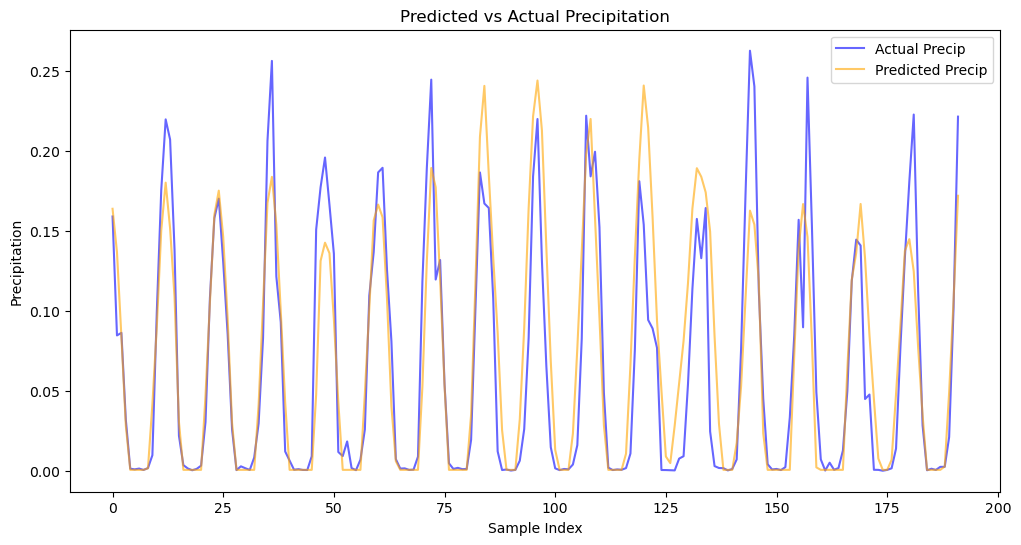

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(df_model['Actual Precip'], label='Actual Precip', color='blue', alpha=0.6)
plt.plot(df_model['Predicted Precip'], label='Predicted Precip', color='orange', alpha=0.6)
plt.title('Predicted vs Actual Precipitation')
plt.xlabel('Sample Index')
plt.ylabel('Precipitation')
plt.legend()
plt.show()

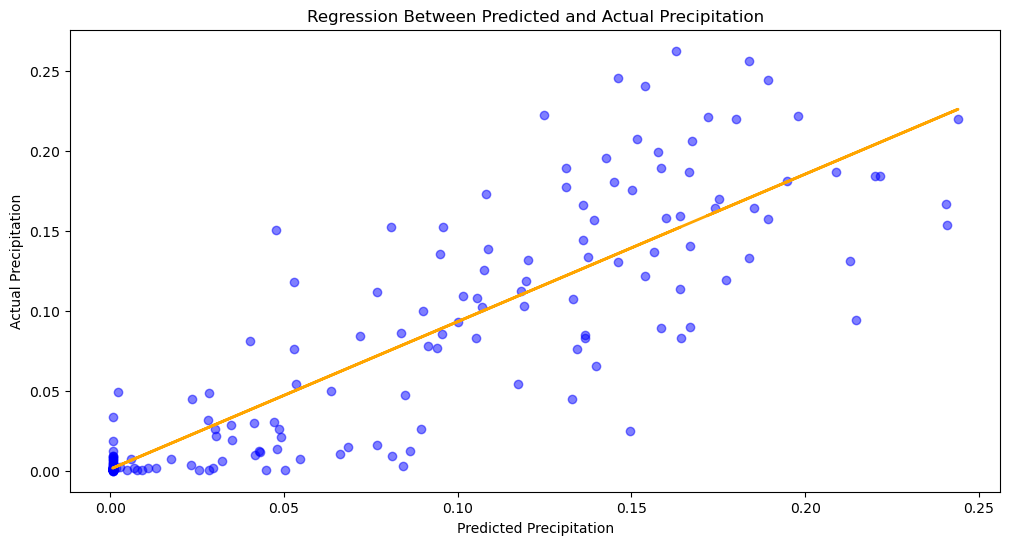

0.92182523 0.0011306554 0.7639148235321045


In [19]:
reg_model = LinearRegression()
X = df_model['Predicted Precip'].values.reshape(-1, 1)  # Features (predicted values)
y = df_model['Actual Precip'].values  # Target (actual values)

# Fit the model
reg_model.fit(X, y)

# Make predictions for the regression line
y_pred = reg_model.predict(X)

# Plotting the regression results
plt.figure(figsize=(12, 6))
plt.scatter(df_model['Predicted Precip'], df_model['Actual Precip'], color='blue', alpha=0.5)
plt.plot(df_model['Predicted Precip'], y_pred, color='orange', linewidth=2, label='Regression Line')
plt.title('Regression Between Predicted and Actual Precipitation')
plt.xlabel('Predicted Precipitation')
plt.ylabel('Actual Precipitation')

plt.show()

m = reg_model.coef_[0]
b = reg_model.intercept_
r2 = r2_score(y, y_pred)

# Print the regression line equation and R^2 value

print(m, b, r2)

# Final Thoughts
### My thought in creating this model was to have precipitation data be used to create the seasonal pattern, and for SST to predict the heights of the peaks. I think much more work is needed to see if the SST adds any improvement to this model, and how can this model be used more effectively. Wet season (Austral Summer) droughts are of huge concern because most agriculture in the region is rainfed and the classic African animals rely on the rains to return each Austral Spring. October and November have had statistically significant decreased precipitation and the rainy season has shown more variability. Better prediction will help with planting drought resistant crops in rain poor seasons and other intellegent sustainability options. 